# 2.5D ResNet

This `.ipynb` will focus on the development of a 2.5D methodology for the previously used ResNet.

Instead of passing the same file to each RGB channel, I'll be working on a robust way to pass the entire batch as sets of 3 consecutive slices.

In [16]:
# ------------ Utils ------------

from newDimUtils import * 

c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


## New Data Loader

The new data loader must be capable of correctly recognizing and assigning consecutive patient-wise slices. It also needs to identify the first and last slices, in order to duplicate them for the previous and next examples, respectively.

This is mostly done through indexing of the `.csv`, which I had previously organized. Each patient and consecutive slice is always aggregated, further facilitating the data loader's task.

In [3]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        

        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random Choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label, patient_id

In [4]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])

augment=False


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])


# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [6]:
warnings.filterwarnings("ignore")

checkShape(train_dataset, df_fibrosis)

SliceID at index 1338: 83__CT-3792-0008.npy

Original np.array shape:
(512, 512)
----------------------

Transformed tensor shape:
torch.Size([3, 224, 224])


SliceID at index 1404: 92__CT-1298-0009.npy
(224, 224, 3)


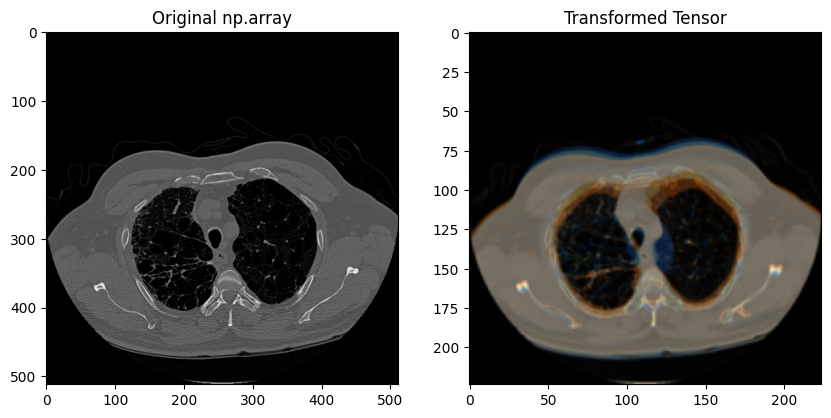

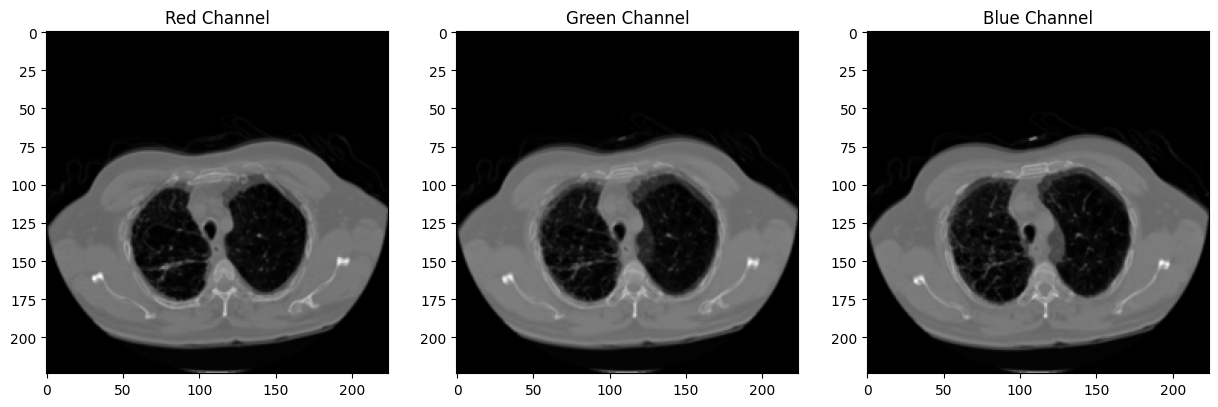

In [8]:
tensorVSnp(train_dataset, df_fibrosis)

The next step is to **run every experiment again...**

## EXTRA: Visualizing Different Manifestations

Due to discrepancies in clusters, identifiable outliers are always assumed to belong to the fibrosis class. However, it is also worth mentioning that the fibrosis class encompasses `early_fibrosis`, `bronchiectasis` and `reticulation`.

After identifying that the model was consistently underperforming in class 1, I initially attributed this issue to outliers in the t-SNE plot. Through further analysis, it's easy to understand that this could not be happening, since I always assume majority voting ties belong to the fibrosis class (in the real world, it would be better to always assume they are sick rather then not, which would then justify the need for further testing). If assuming different manifestations as fibrosis were, in fact, hindering classification, then **class 1 would be over-classified, and not the other way around**, as I am simply encouraging the model (in this case, proximity clusters) to assume fibrosis presence.

As a sanity check, I'll dedicate this subsection to the visualization (and possibly new result assessment) of separate manifestations as fibrosis. I'll be working on ways to eliminate assumption, such as considering anything other than fibrosis to belong to class 0, comparing result performance. 

The main goal is to understand how close some slices are to being identified as healthy, when observing them in a t-SNE, distorted space context. It does not mean that patients are actually healthy, but simply rearranging outliers can change cluster shapes and proximities, potentially improving model correctness and performance.

The code below will help me find the slices with different manifestations of fibrosis, through parsing of `.txt` ROI files. It can detect all 3 aforementioned aggregated manifestations, and return the folder in which they were found, as well as the indexes of the slices with said manifestation:

In [28]:
import os
import re

root = r"..\\..\\..\\fibrosis_dataset\ILD_DB_txtROIs"

In [29]:
def load_roi_files(roi_file_name):
    # List to store all the ROIs
    rois = []

    # Open the ROI file for reading
    with open(roi_file_name, 'r') as file:
        roi = {}
        while True:
            # Read a line from the file
            line = file.readline()
            
            # Stop if we reach the end of the file
            if not line:
                break

            # Check and parse each line based on its prefix
            if 'label:' in line:
                roi['label'] = line.replace('label: ', '').strip()
            elif 'slice_number:' in line:
                roi['slice_number'] = float(line.replace('slice_number: ', '').strip())

                # Append the parsed ROI to the list of ROIs
                rois.append(roi)
                roi = {}  # Reset for the next ROI

    return rois

In [47]:
def searchDiffManifest(folder, verbose=1):

    target_labels = {"early_fibrosis", "bronchiectasis", "reticulation"}
    manifest_dict = {label: {} for label in target_labels}
    ctr=0

    for root, dirs, files in os.walk(folder):
        folder_name = os.path.basename(root)

        for file in files:
            if not file.endswith(".txt"):
                continue

            txt_file_path = os.path.join(root, file)
            rois = load_roi_files(txt_file_path)

            if not rois or not isinstance(rois[0], dict):
                continue

            if verbose == 1:
                first_label = rois[0].get('label', None)
                if first_label in target_labels:
                    print(f"Searching in folder: {folder_name}")
                    print(f"{file}\n")
                    for d in rois:
                        print(d)
                        for key in d.items(): 
                            if "slice_number" in key: ctr+=1
                    print("\n" + "="*50 + "\n\n")
            else:
                current_label = None
                for roi in rois:
                    if 'label' in roi and roi['label'] in target_labels:
                        current_label = roi['label']

                    if current_label and 'slice_number' in roi:
                        slice_num = int(roi['slice_number'])

                        # Insert into correct dictionary
                        if folder_name not in manifest_dict[current_label]:
                            manifest_dict[current_label][folder_name] = []

                        manifest_dict[current_label][folder_name].append(slice_num)

    if verbose != 1:
        return manifest_dict

    print(ctr)


In [48]:
searchDiffManifest(root)

Searching in folder: 107
CT-INSPIRIUM-3684.txt

{'label': 'reticulation', 'slice_number': 12.0}
{'slice_number': 13.0}
{'slice_number': 14.0}
{'slice_number': 15.0}
{'slice_number': 16.0}
{'slice_number': 17.0}
{'slice_number': 18.0}
{'slice_number': 19.0}
{'label': 'ground_glass', 'slice_number': 11.0}
{'slice_number': 12.0}
{'slice_number': 15.0}



Searching in folder: 108
CT-INSPIRIUM-6415.txt

{'label': 'reticulation', 'slice_number': 18.0}
{'slice_number': 19.0}
{'slice_number': 20.0}
{'slice_number': 21.0}
{'label': 'ground_glass', 'slice_number': 9.0}
{'slice_number': 10.0}
{'slice_number': 11.0}
{'slice_number': 13.0}



Searching in folder: 128
CT-Thx-HR-1-10-mm-inspiration-0007.txt

{'label': 'reticulation', 'slice_number': 22.0}
{'slice_number': 23.0}
{'slice_number': 24.0}
{'slice_number': 25.0}
{'slice_number': 26.0}
{'slice_number': 29.0}
{'slice_number': 30.0}
{'slice_number': 31.0}
{'slice_number': 32.0}
{'slice_number': 33.0}
{'slice_number': 34.0}
{'slice_number': 35

Now that we have seen the parsing process, I can change it so that it fits our main purpose:

In [41]:
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

train_ds = pd.read_csv(annotations_file_train)
val_ds = pd.read_csv(annotations_file_val)

manifest_dict = searchDiffManifest(root,verbose=0)

This will allow me to use the current data split dataframe, and extract each relevant `SliceID`, placing them into a new, custom dataframe:

In [57]:
def manifestationDataframe(manifest_dict, df):

    full_df = df
    result_rows = []
    slice_manifestation_map = {}  # To track manifestations per sliceID

    # Step 2: Iterate through manifestations and patients
    for manifestation, patients in manifest_dict.items():
        for folder_name, slice_indexes in patients.items():
            pseudo_patient_id = folder_name + "_"

            # Step 2.1: Get all rows matching the pseudo_patient_id
            matching_rows = full_df[full_df["SliceID"].str.contains(pseudo_patient_id, na=False)]


            if matching_rows.empty:
                print(f"⚠️ Warning: Folder '{folder_name}' not found in train/val datasets.")
                continue

            # Matching rows are sequential 
            matching_rows = matching_rows.reset_index(drop=True)

            # Step 2.1.1: Filter only those with slice index in slice_indexes
            filtered_rows = [
                row for i, row in matching_rows.iterrows()
                if i in slice_indexes
            ]

            # Step 2.2: Add each match to the result list and track manifestations
            for row in filtered_rows:
                slice_id = row["SliceID"]
                if slice_id not in slice_manifestation_map:
                    slice_manifestation_map[slice_id] = set()

                # Check if slice already has manifestations
                if slice_manifestation_map[slice_id] and manifestation not in slice_manifestation_map[slice_id]:
                    existing = slice_manifestation_map[slice_id]
                    print(f"⚠️ Warning: SliceID '{slice_id}' has multiple manifestations: {existing} + '{manifestation}'")

                slice_manifestation_map[slice_id].add(manifestation)

                result_rows.append({
                    "SliceID": slice_id,
                    "Manifestation": manifestation
                })

    # Step 3: Return result as a DataFrame
    return pd.DataFrame(result_rows)


In [ ]:
full_df = pd.concat([train_ds, val_ds], ignore_index=True)

manifest_df = manifestationDataframe(manifest_dict, full_df)

⚠️ Warning: Folder '12' not found in train/val datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8871' not found in train/val datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8873' not found in train/val datasets.
⚠️ Warning: Folder '108' not found in train/val datasets.
⚠️ Warning: Folder '150' not found in train/val datasets.
⚠️ Warning: Folder '155' not found in train/val datasets.
⚠️ Warning: Folder '157' not found in train/val datasets.


Some folder were not foun in the train + validation dataframe. If everything was done correctly, then all of the folders above must be present in the test dataframe:

In [60]:
annotations_file_test = r"..\trainTestCustom\test.csv"

test_ds = pd.read_csv(annotations_file_test)

manifest_df_test = manifestationDataframe(manifest_dict, test_ds)

⚠️ Warning: Folder '165' not found in train/val datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-2951' not found in train/val datasets.
⚠️ Warning: Folder '21' not found in train/val datasets.
⚠️ Warning: Folder '46' not found in train/val datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-3550' not found in train/val datasets.
⚠️ Warning: Folder '90' not found in train/val datasets.
⚠️ Warning: Folder '204' not found in train/val datasets.
⚠️ Warning: Folder '207' not found in train/val datasets.
⚠️ Warning: Folder '208' not found in train/val datasets.
⚠️ Warning: Folder '107' not found in train/val datasets.
⚠️ Warning: Folder '128' not found in train/val datasets.
⚠️ Warning: Folder '177' not found in train/val datasets.
⚠️ Warning: Folder '179' not found in train/val datasets.
⚠️ Warning: Folder '181' not found in train/val datasets.
⚠️ Warning: Folder '46' not found in train/val datasets.


Now each warning identifies all cases present in the train_val dataframe, meaning everything was done correctly.